In [1]:
## DeepExplain - Keras (TF backend) example
### MNIST with CNN
%load_ext autoreload
%autoreload 2

In [2]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
import tensorflow as tf
import scipy

# Import DeepExplain
from deepexplain.tensorflow import DeepExplain, ProbDense

#Import DeepLift
import deeplift
from deeplift.layers import NonlinearMxtsMode
from deeplift.conversion import kerasapi_conversion as kc
from deeplift.util import compile_func


Using TensorFlow backend.


In [3]:
# Build and train a network.

SKIP_TRAIN = False
saved_model_file = 'model.h5'
saved_model_weights_file = 'model_w.h5'

batch_size = 128
num_classes = 10
epochs = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.array([scipy.misc.imresize(x, (img_rows,img_cols,)) for x in x_train])
x_test = np.array([scipy.misc.imresize(x, (img_rows,img_cols,)) for x in x_test])



#x_train = x_train.reshape(-1, 28,28,1)
#x_test = x_test.reshape(-1, 28,28,1)
x_train = x_train.reshape(-1, img_rows*img_cols)
x_test = x_test.reshape(-1, img_rows*img_cols)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = (x_train - 0.5) * 2
x_test = (x_test - 0.5) * 2
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
reg = keras.regularizers.l2(0.001)
def f(x):
    return x*tf.sigmoid(x)

if SKIP_TRAIN:
    model = load_model(saved_model_file)
else:
    #de.enable_override('shapley')
    model = Sequential()
    #model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(28,28,1)))
    #model.add(Conv2D(64, (3, 3), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))
    #model.add(Flatten())
    model.add(Dense(128, input_shape=(img_rows*img_cols,), activation='relu', kernel_regularizer=reg))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu', kernel_regularizer=reg))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu', kernel_regularizer=reg))
    model.add(Dense(num_classes, kernel_regularizer=reg))
    model.add(Activation('softmax'))
    # ^ IMPORTANT: notice that the final softmax must be in its own layer 
    # if we want to target pre-softmax units

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    model.save(saved_model_file)
    model.save_weights(saved_model_weights_file)

    print (model.layers[0].get_weights()[1].mean())
    print (model.layers[0].get_weights()[1].var())
    
#score = model.evaluate(x_test, y_test, verbose=0)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


x_train shape: (60000, 784)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 129us/step - loss: 0.9543 - acc: 0.8148 - val_loss: 0.6091 - val_acc: 0.9064
Epoch 2/10
60000/60000 [==============================] - 1s 23us/step - loss: 0.5797 - acc: 0.9102 - val_loss: 0.4179 - val_acc: 0.9518
Epoch 3/10
60000/60000 [==============================] - 1s 24us/step - loss: 0.4738 - acc: 0.9274 - val_loss: 0.4015 - val_acc: 0.9395
Epoch 4/10
60000/60000 [==============================] - 1s 23us/step - loss: 0.4198 - acc: 0.9352 - val_loss: 0.3630 - val_acc: 0.9485
Epoch 5/10
60000/60000 [==============================] - 2s 29us/step - loss: 0.3805 - acc: 0.9386 - val_loss: 0.3256 - val_acc: 0.9549
Epoch 6/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.3577 - acc: 0.9428 - val_loss: 0.2744 - val_acc: 0.9647
Epoch 7/10
60000/60000 [==============================] - 2s

In [4]:
features = img_rows*img_cols
input_shape = (features,)
probModel = Sequential()
probModel.add(ProbDense(128, input_shape=input_shape, first=True, kn=100, activation='relu'))
probModel.add(ProbDense(128, activation='relu'))
probModel.add(ProbDense(64, activation='relu'))
probModel.add(ProbDense(num_classes))
probModel.load_weights(saved_model_weights_file)



In [25]:
xs = x_test[0:1]
ys = y_test[0:1]

In [26]:
# Deep Shapley

noSoftmaxModel = Model(inputs=model.layers[0].input, outputs = model.layers[-2].output)
y = noSoftmaxModel.predict(xs)


def compute_deepshap():
    ny = probModel.predict(xs)
    print (ny.shape)

    S = ny
    S = np.stack([S[i, :, :, np.argmax(ys[i]), :] for i in range(len(ys))], axis=0)

    S = S[:,:,:, 1] - S[:,:,:, 0]
    S = np.mean(S, 1)


# compute shapley value
a_shap = compute_deepshap()
assert not np.isnan(S).any()


(1, 112, 784, 10, 4)


In [7]:

#S = np.reshape(ny, [-1, len(xs), ny.shape[-3], ny.shape[-2], ny.shape[-1]])
#print (S.shape)


(10, 112, 784, 4)
[ 0.00156111 -0.00430381 -0.00773221 -0.01065516 -0.01308089 -0.01566184
 -0.01800042 -0.01961547 -0.02087453 -0.02201898 -0.02307159 -0.0239693
 -0.02466139 -0.02515283 -0.02548856 -0.02572083 -0.02588946 -0.02601779
 -0.02611488 -0.02617747 -0.02619237 -0.0261566  -0.0260852  -0.02599096
 -0.02586758 -0.02569711 -0.02547598 -0.02522373 -0.02497613 -0.02476823
 -0.02461374 -0.02450991 -0.02443969 -0.02438676 -0.02433884 -0.02429152
 -0.02424538 -0.02420092 -0.02416015 -0.02412152 -0.02408528 -0.02404928
 -0.02401066 -0.02397084 -0.02393079 -0.02388573 -0.02384257 -0.02379656
 -0.02375126 -0.02370596 -0.02366138 -0.02361798 -0.02357674 -0.0235374
 -0.02350068 -0.02346516 -0.02343035 -0.0234015  -0.02337384 -0.02334714
 -0.02332425 -0.02330399 -0.02328491 -0.02326918 -0.02325463 -0.02324295
 -0.02323341 -0.02322721 -0.02321911 -0.02321529 -0.02321339 -0.02321243
 -0.02321339 -0.02321291 -0.02321577 -0.02321672 -0.02322054 -0.02322578
 -0.02322912 -0.02323341 -0.0232372

In [8]:

%matplotlib inline
aModel = Model(inputs=model.inputs, outputs=[model.layers[1].input])
y = aModel.predict(x_test)
import matplotlib.pyplot as plt
#plt.hist(model.layers[1].get_weights()[0].flatten(), 100)
#plt.hist(y.flatten(), 100)

In [9]:
%time
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    

    
    a_gradin = de.explain('grad*input', target_tensor * ys, input_tensor, xs)
    #attributions = de.explain('saliency', target_tensor * ys, input_tensor, xs)
    a_intgrad = de.explain('intgrad', target_tensor * ys, input_tensor, xs)
    a_res = de.explain('deeplift', target_tensor * ys, input_tensor, xs)
    a_rc = de.explain('deeplift_rc', target_tensor * ys, input_tensor, xs)
    #a_linear = de.explain('linear', target_tensor * ys, input_tensor, xs)
    a_layershap = de.explain('shapley', target_tensor * ys, input_tensor, xs)
    #a_shap = np.zeros_like(a_linear)
    
    #attributions2 = de.explain('elrp', target_tensor * ys, input_tensor, xs)
    #attributions = de.explain('occlusion', target_tensor * ys, input_tensor, xs)
    print ("Done")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.53 µs
DeepExplain: running "grad*input" explanation method (2)
Model with multiple inputs:  False
{<tf.Tensor 'dense_1_input:0' shape=(?, 784) dtype=float32>: array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32), <tf.Tensor 'dropout_1/keras_learning_phase/input:0' shape=() dtype=bool>: 0}
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
{<tf.Tensor 'dense_1_input:0' shape=(?, 784) dtype=float32>: array([[-0.01, -0.01, -0.01, ..., -0.01, -0.01, -0.01],
       [-0.01, -0.01, -0.01, ..., -0.01, -0.01, -0.01],
       [-0.01, -0.01, -0.01, ..., -0.01, -0.01, -0.01],
       ...,
       [-0.01, -0.01, -0.01, ..., -0.01, -0.01, -0.01],
       [-0.01, -0.01, -0.01

/home/anconam/projects/DeepExplain/deepexplain/tensorflow/deep_shapley.py:413: RuntimeWarning: divide by zero encountered in true_divide
  t = (i / (2 * vars[:, :, np.newaxis] * Xs[np.newaxis, np.newaxis, :]) ** 0.5)
/home/anconam/projects/DeepExplain/deepexplain/tensorflow/deep_shapley.py:414: RuntimeWarning: divide by zero encountered in true_divide
  tb = (ib / (2 * vars[:, :, np.newaxis] * Xs[np.newaxis, np.newaxis, :]) ** 0.5)
/home/anconam/projects/DeepExplain/deepexplain/tensorflow/deep_shapley.py:420: RuntimeWarning: overflow encountered in square
  exp1 = e ** -(t ** 2)
/home/anconam/projects/DeepExplain/deepexplain/tensorflow/deep_shapley.py:421: RuntimeWarning: overflow encountered in square
  exp2 = e ** -(tb ** 2)
/home/anconam/projects/DeepExplain/deepexplain/tensorflow/deep_shapley.py:453: RuntimeWarning: invalid value encountered in true_divide
  eta =  np.where(np.abs(deltas) > 1e-6, shap / deltas, np.zeros_like(shap))


None
MatMul override:  model_3/dense_2/MatMul
Players (10, 128)
Weights (128, 128)
Reference (1, 128)
Original grad (?, 128)
Eta shap [approx] games[(10, 128, 128)], bias[(128,)], baseline[(10, 128, 128)]
Reshape: games[(10, 128, 128)], bias[(128,)], baseline[(10, 128, 128)]
None
MatMul override:  model_3/dense_1/MatMul
Players (10, 784)
Weights (784, 128)
Reference (1, 784)
Original grad (?, 784)
Eta shap [approx] games[(10, 784, 128)], bias[(128,)], baseline[(10, 784, 128)]
Reshape: games[(10, 784, 128)], bias[(128,)], baseline[(10, 784, 128)]
{<tf.Tensor 'dense_1_input:0' shape=(?, 784) dtype=float32>: array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32), <tf.Tensor 'dropout_1/keras_learning_phase/input:0' shape=() dtype=bool>: 0}
Done


In [10]:
# Compute exacly shapley values!
saved_file = 'exact.npy'
a_exact = np.zeros_like(a_gradin)
if True or not SKIP_TRAIN:
    from deepexplain.tensorflow.exact_shapley import compute_shapley
    a_exact = np.array([compute_shapley(xx, lambda x: (fModel.predict(np.array(x))*yy).sum(-1)) for xx, yy in zip(xs, ys)])
    np.save(saved_file, a_exact)
else:
    a_exact = np.load(saved_file)


ValueError: Maximum allowed size exceeded

In [ ]:
print (a_exact)
print (a_exact[0].sum())

In [ ]:
%%script false
import shap
import numpy as np

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]#.mean(0, keepdims=True)
#background = np.zeros_like(background)

# explain predictions of the model on four images
e = shap.DeepExplainer((model.layers[0].input, model.layers[-2].output), background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(xs)
y_ = np.argmax(ys, 1)
npshap = np.array(shap_values)
#npshap = npshap.reshape(10, 15, -1)
#shap_values = np.transpose(shap_values, (1, 0, 2, 3, 4))
a_shaplud = np.array([npshap[item, enum] for enum, item in enumerate(y_)])
print (a_shaplud.shape)

# plot the feature attributions
#shap.image_plot(shap_values, -xs)

Text(0.5, 1.0, 'Exact Shap')

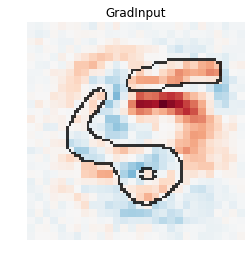

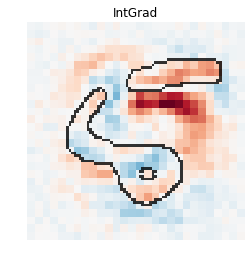

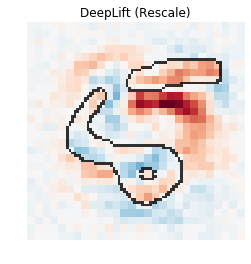

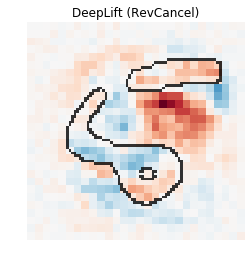

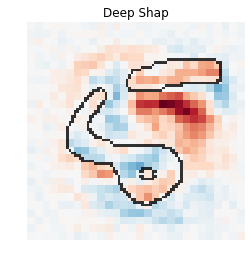

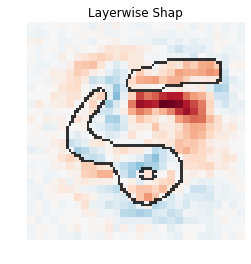

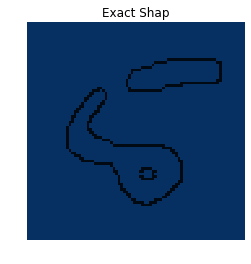

In [19]:
# Plot attributions
from utils import plot, plt
%matplotlib inline
idx = 8
plot(a_gradin[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('GradInput')
plt.figure()
plot(a_intgrad[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('IntGrad')
plt.figure()
plot(a_res[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('DeepLift (Rescale)')
#plt.figure()
#plot((a_linear)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('Linear')
plt.figure()
plot(a_rc[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('DeepLift (RevCancel)')
plt.figure()
plot((a_shap)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('Deep Shap')
plt.figure()
plot((a_layershap)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('Layerwise Shap')
plt.figure()
#plot((a_shaplud)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('SHAP')
#plt.figure()
plot((a_exact)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('Exact Shap')


        
        


In [ ]:
a_shaplud = np.zeros_like(a_shap)
methods = [a_gradin, a_intgrad, a_res, a_rc, a_shap, a_layershap, a_exact]
confusion = np.zeros((len(methods), len(methods)))
confusion[:] = np.nan
confusion_r = np.zeros((len(methods), len(methods)))
confusion_r[:] = np.nan

n = a_gradin.shape[0]
for i, m1 in enumerate(methods):
    for j, m2 in enumerate(methods):
        if i >= j:
            m1 = m1.reshape(n, -1)
            m2 = m2.reshape(n, -1)
            confusion[i][j] = ((m1-m2)**2).mean()
            confusion_r[i][j] = np.mean([scipy.stats.kendalltau(x, y)[0] for x,y in zip(m1, m2)])
            confusion[j][i] = confusion[i, j]
            confusion_r[j][i] = confusion_r[i, j]
plt.figure()
plt.matshow(confusion, cmap='RdBu_r')
plt.colorbar()
plt.figure()
plt.matshow(confusion_r, cmap='RdBu_r')
plt.colorbar()
#print ('MSE with SHAP ', confusion[-1][-2])
comparison = -3
print ('MSE with Layerwise Shap ', confusion[-2][comparison])
print ('MSE with DeepShap ', confusion[-3][comparison])
print ('MSE with DeepLift ', confusion[-4][comparison])
print ('MSE with DeepLift (Rescale) ', confusion[-5][comparison])
print ('MSE with Int Gradients ', confusion[-6][comparison])
print ('MSE with GradInput ', confusion[-7][comparison])

#print ('Kendall corr. with SHAP ', confusion_r[-1][-2])
print ('Kendall corr.  with Layerwise Shap ', confusion_r[-2][comparison])
print ('Kendall corr.  with DeepShap ', confusion_r[-3][comparison])
print ('Kendall corr.  with DeepLift ', confusion_r[-4][comparison])
print ('Kendall corr.  with DeepLift (rescale)', confusion_r[-5][comparison])
print ('Kendall corr.  with Int Gradients ', confusion_r[-6][comparison])
print ('Kendall corr.  with GradInput ', confusion_r[-7][comparison])

In [ ]:
from deepexplain.tensorflow.accuracy_robustness import run_robustness_test
original_maps = [a_gradin, a_intgrad, a_res, a_rc, a_shap, a_layershap]
names = ['GradInput', 'IntGrad', 'DeepLift (Recale)', 'DeepLift (RevCanc)', 'ApprShapley', 'Layer Shap']
run_robustness_test(fModel, xs, ys, original_maps, names, 'Test', 1,
                        result_path='.', mode='prediction', reduce_dim=None)



In [ ]:
from deepexplain.tensorflow.sensitivityn import run_sensitivity_test
run_sensitivity_test(fModel, xs, ys, original_maps, names, 'Test',
                        result_path='.', number_of_samples=1000)


In [ ]:
%%script false

# Compute DeepLift attributions
revealcancel_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)
rescale_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.Rescale)

revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
rescale_func = rescale_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)

a_rc = np.array([np.array(revealcancel_func(
                task_idx=np.argmax(y),
                input_data_list=[[x]],
                input_references_list=[[np.zeros_like(x)]],
                batch_size=100,
                progress_update=None)) for x, y in zip(xs,ys)])

a_res = np.array([np.array(rescale_func(
                task_idx=np.argmax(y),
                input_data_list=[[x]],
                input_references_list=[[np.zeros_like(x)]],
                batch_size=100,
                progress_update=None)) for x, y in zip(xs,ys)])
print (a_rc.shape)

In [ ]:
# Randomization test
heatmaps = []
the_model = probModel
original_weights = []
attribute_f = compute_deepshap

for i, l in enumerate(the_model.layers[::-1]):
    if (len(l.get_weights())):
        original_weights.append(l.get_weights())
        # Replace weights with random
        new_weights = [np.random.normal(size=w.shape) for w in l.get_weights()]
        l.set_weights(new_weights)
        print (i)
        heatmaps.append(attribute_f())
        
        
# Restore weights
for i, l in enumerate(the_model.layers[::-1]):
    if (len(l.get_weights())):
        l.set_weights(original_weights[i])

1
